# Courier Predict EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEED = 42
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Загружаем данные

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
facts_df = pd.read_csv('facts.csv')
shifts_df = pd.read_csv('shifts_prediction.csv')

**shifts_prediction.csv:**
- calendar_dt - дата в формате YYYY-MM-DD
- store_id - идентификатор даркстора
- predicted_staff_value - предсказанное число человек, необходимое, чтобы обслужить все заказы на неделе прогноза,
- predicted_num_orders - предсказанное число заказов на неделю прогноза,
- predicted_load_factor - предсказанная нагрузка на курьеров (число заказов в час, которое приходится на одного курьера) на неделю прогноза.

**facts.csv:**
- calendar_dt - дата в формате YYYY-MM-DD
- store_id - идентификатор даркстора
- fact_staff_value_lag_1 - фактическое число человек, необходимое, чтобы обслужить все заказы на прошлой неделе,
- fact_load_factor_lag_1 - фактическая нагрузка на курьеров на прошлой неделе,
- num_available_couriers_lag_1 - число курьеров, предложивших свои услуги за предыдущую неделю,
- fact_num_orders_lag_1 - фактическое число заказов за предыдущую неделю,
- fact_percent_lateness_lag_1 - процент опозданий за предыдущую неделю,
- store_lifetime_in_days - число дней функционирования даркстора,
- city_nm - город функционирования даркстора,
- fact_staff_churn - число курьеров, уволившихся из компании,
- flag_high_load_lag_1 - признак повышенного спроса за предыдущую неделю,
- marketing_costs_lag_1 - затраты на маркетинг, осуществленные за предыдущую неделю,
- fact_couriers_with_shifts_lag_1 - число курьеров, выходивших на смены на предыдущей неделе.

## Первый просмотр

In [4]:
train_df.head(3)

,calendar_dt,store_id,target
0,2025-11-03,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1.00000
1,2025-11-10,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1.00000
2,2025-11-17,000fade4-e8dc-11ed-b10a-08c0eb31fffb,4.00000


In [5]:
test_df.head(3)

,store_id
0,000fade4-e8dc-11ed-b10a-08c0eb31fffb
1,0022f1b0-b8f8-11ee-b10b-08c0eb31fffb
2,00440ac1-6a1d-11eb-85a3-1c34dae33151


In [6]:
facts_df.head(3)

,calendar_dt,store_id,fact_staff_value_lag_1,fact_load_factor_lag_1,num_available_couriers_lag_1,fact_num_orders_lag_1,fact_percent_lateness_lag_1,city_nm,store_lifetime_in_days,fact_staff_churn,flag_high_load_lag_1,marketing_costs_lag_1,fact_couriers_with_shifts_lag_1
0,2025-11-03,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1,0.52632,10,10,NaN,Ульяновск,888.00000,1.00000,1,368357734.51660,19.00000
1,2025-11-10,000fade4-e8dc-11ed-b10a-08c0eb31fffb,8,1.94118,13,33,69.56522,Ульяновск,895.00000,1.00000,1,NaN,17.00000
2,2025-11-17,000fade4-e8dc-11ed-b10a-08c0eb31fffb,8,2.40000,12,36,66.66667,Ульяновск,902.00000,4.00000,1,42545024115.87992,15.00000


In [7]:
shifts_df.head(3)

,calendar_dt,store_id,predicted_staff_value,predicted_num_orders,predicted_load_factor
0,2024-01-01,000fade4-e8dc-11ed-b10a-08c0eb31fffb,12,270,2.85000
1,2024-01-08,000fade4-e8dc-11ed-b10a-08c0eb31fffb,14,310,2.85000
2,2024-01-15,000fade4-e8dc-11ed-b10a-08c0eb31fffb,15,370,2.96000


Работать с несколькими датасетами неудобно, надо соединить в один. Для этого смержим датасеты по id и дате. Дату надо для начала обработать. 

## Соединение данных

In [8]:
for df in [train_df, facts_df, shifts_df]:
    df['calendar_dt'] = pd.to_datetime(df['calendar_dt'])

Для каждой строки в train.csv:  
- Берем дату (calendar_dt)  
- Ищем факты за неделю ДО этой даты (facts.csv, calendar_dt = train_dt - 7 дней)  
- Ищем прогнозы НА эту дату (shifts.csv, calendar_dt = train_dt)  
- Объединяем всё вместе + target из train.csv  

То есть в train берем любую дату, из shifts на эту дату берем другие прогнозы. Далее берем дату train - 7 дней и под этой датой берем данные из facts. 

In [25]:
# Создаем колонку с датой неделю назад
train_data = train_df.copy()
train_data['prev_week'] = train_data['calendar_dt'] - pd.Timedelta(days=7)

In [26]:
# Соединение с facts по предыдущей неделе
train_merged = train_data.merge(
    facts_df, 
    left_on=['store_id', 'prev_week'],
    right_on=['store_id', 'calendar_dt'], 
    how='left',
    suffixes=('', '_facts')
)

In [27]:
# Соединение с shifts по текущей неделе
train_merged = train_merged.merge(
    shifts_df,
    on=['store_id', 'calendar_dt'],
    how='left',
    suffixes=('', '_shifts')
)

In [28]:
# Удаляем временную колонку
train_merged = train_merged.drop(columns=['prev_week'])

## Продолжение анализа

In [11]:
train_merged.head(3)

,calendar_dt,store_id,target,fact_staff_value_lag_1,fact_load_factor_lag_1,num_available_couriers_lag_1,fact_num_orders_lag_1,fact_percent_lateness_lag_1,city_nm,store_lifetime_in_days,fact_staff_churn,flag_high_load_lag_1,marketing_costs_lag_1,fact_couriers_with_shifts_lag_1,predicted_staff_value,predicted_num_orders,predicted_load_factor
0,2025-11-03,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1.00000,1,0.52632,10,10,NaN,Ульяновск,888.00000,1.00000,1,368357734.51660,19.00000,7.00000,260.00000,4.96000
1,2025-11-10,000fade4-e8dc-11ed-b10a-08c0eb31fffb,1.00000,8,1.94118,13,33,69.56522,Ульяновск,895.00000,1.00000,1,NaN,17.00000,6.00000,290.00000,5.06000
2,2025-11-17,000fade4-e8dc-11ed-b10a-08c0eb31fffb,4.00000,8,2.40000,12,36,66.66667,Ульяновск,902.00000,4.00000,1,42545024115.87992,15.00000,7.00000,280.00000,4.86000


In [12]:
train_merged.describe()

,calendar_dt,target,fact_staff_value_lag_1,fact_load_factor_lag_1,num_available_couriers_lag_1,fact_num_orders_lag_1,fact_percent_lateness_lag_1,store_lifetime_in_days,fact_staff_churn,flag_high_load_lag_1,marketing_costs_lag_1,fact_couriers_with_shifts_lag_1,predicted_staff_value,predicted_num_orders,predicted_load_factor
count,8220,8220.00000,8220.00000,8111.00000,8220.00000,8220.00000,5763.00000,8220.00000,8220.00000,8220.00000,5736.00000,8111.00000,8219.00000,8219.00000,8219.00000
mean,2025-10-09 10:18:13.138685952,2.37859,6.58929,2.73675,10.81509,30.77968,78.39218,969.03139,1.81338,0.67007,42963090051.34943,12.67316,8.20197,326.63219,5.28198
min,2024-01-01 00:00:00,0.00000,1.00000,0.00000,0.00000,0.00000,2.70270,0.00000,0.00000,0.00000,7559.29128,1.00000,1.00000,0.00000,2.00000
25%,2025-11-03 00:00:00,0.00000,1.00000,1.25000,9.00000,10.00000,66.66667,492.00000,0.00000,0.00000,62708165.07817,9.00000,6.00000,240.00000,4.20000
50%,2025-11-10 00:00:00,2.00000,7.00000,2.47368,10.00000,30.00000,82.60870,903.00000,1.00000,1.00000,445088537.95527,12.00000,7.00000,300.00000,5.07000
75%,2025-11-17 00:00:00,4.00000,9.00000,3.58114,12.00000,43.00000,97.40216,1448.00000,3.00000,1.00000,3615568547.19991,15.00000,10.00000,400.00000,6.00000
max,2025-11-17 00:00:00,31.00000,40.00000,45.00000,41.00000,210.00000,100.00000,2520.00000,5.00000,1.00000,62838677091818.85156,40.00000,28.00000,1090.00000,12.85000
std,NaN,2.73842,4.72988,2.00708,3.86839,18.80750,20.65511,585.78129,1.84533,0.47021,917289963632.06128,5.13299,3.34466,128.36295,1.41743


### Пропуски в данных

In [13]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8220 entries, 0 to 8219
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   calendar_dt                      8220 non-null   datetime64[ns]
 1   store_id                         8220 non-null   object        
 2   target                           8220 non-null   float64       
 3   fact_staff_value_lag_1           8220 non-null   int64         
 4   fact_load_factor_lag_1           8111 non-null   float64       
 5   num_available_couriers_lag_1     8220 non-null   int64         
 6   fact_num_orders_lag_1            8220 non-null   int64         
 7   fact_percent_lateness_lag_1      5763 non-null   float64       
 8   city_nm                          8220 non-null   object        
 9   store_lifetime_in_days           8220 non-null   float64       
 10  fact_staff_churn                 8220 non-null   float64    

**Пропуски:**  
Есть следующие пропуски:  
- fact_staff_value_lag_1 (фактическое число человек, необходимое, чтобы обслужить все заказы на прошлой неделе): *5763/8220*  
- fact_load_factor_lag_1 (фактическая нагрузка на курьеров на прошлой неделе): *5669/8220*   
- num_available_couriers_lag_1 (число курьеров, предложивших свои услуги за предыдущую неделю): *5763/8220*  
- fact_num_orders_lag_1 (фактическое число заказов за предыдущую неделю): *5763/8220*  
Причина пропусков: у только что открывшихся дарксторов нет информации о прошлой неделе.

Есть пропуски такие как:
- fact_percent_lateness_lag_1 (процент опозданий за предыдущую неделю): *3310/8220*  
Причиной таких пропусков может быть отсутсвие у даркстора заказов на неделе

Пропуск в:  
- marketing_costs_lag_1 (затраты на маркетинг, осуществленные за предыдущую неделю): *4040/8220*  
Причина пропусков: компания может и не выделять деньги на маркетинг для дарксторов  

### Распределение таргета

Минимальное:  0.0
Среднее:  2.378588807785888
Максимальное:  31.0
Медиана:  2.0


<Axes: ylabel='Density'>

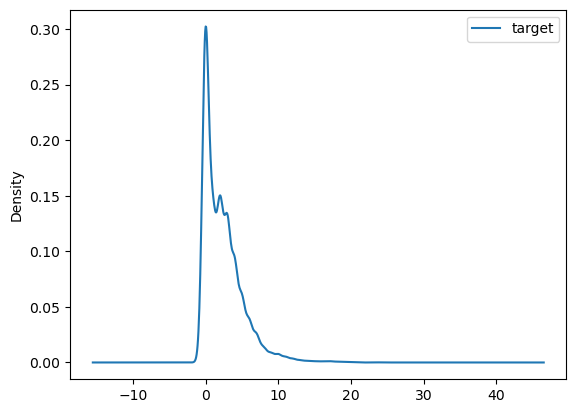

In [14]:
print("Минимальное: ", train_merged.target.min())
print("Среднее: ", train_merged.target.mean())
print("Максимальное: ", train_merged.target.max())
print("Медиана: ", train_merged.target.median())
train_merged.target.plot.kde(legend=True)

В большинстве таргет находится в диапазоне от 0 до 5  

### Матрица кореляций

In [15]:
def plot_corr(df):
    """Нарисовать матрицу корреляций"""
    corr = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

In [18]:
cols_for_conf_matrix = ["calendar_dt", "store_id", "target", "city_nm"]

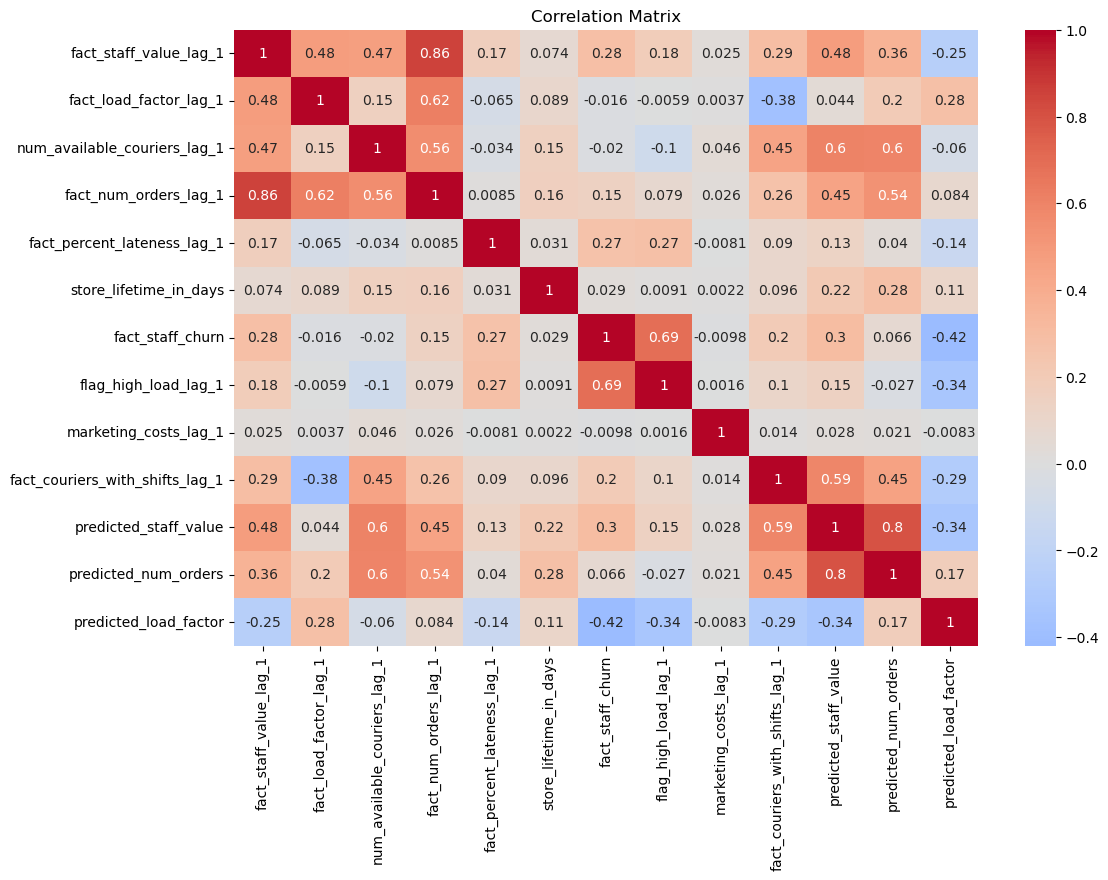

In [19]:
plot_corr(train_merged.drop(columns=cols_for_conf_matrix))

Из матрицы кореляций видно, что есть сильно коррелирующие колонки - fact_staff_value_lag_1 и fact_num_orders_lag_1

In [29]:
# тестовые данные
test_date = pd.to_datetime('2025-11-24')
prev_week = test_date - pd.Timedelta(days=7)

In [30]:
test_data = test_df.copy()
test_data['calendar_dt'] = test_date
test_data['prev_week'] = prev_week

In [31]:
# Соединение с facts по предыдущей неделе
test_merged = test_data.merge(
    facts_df[facts_df['calendar_dt'] == prev_week], 
    left_on=['store_id', 'prev_week'],
    right_on=['store_id', 'calendar_dt'],
    how='left',
    suffixes=('', '_facts')
)

In [32]:
# Соединение с shifts по текущей неделе
test_merged = test_merged.merge(
    shifts_df[shifts_df['calendar_dt'] == test_date], 
    left_on=['store_id', 'calendar_dt'],
    right_on=['store_id', 'calendar_dt'],
    how='left',
    suffixes=('', '_shifts')
)

In [33]:
# Удаляем временные колонки
test_merged = test_merged.drop(columns=['prev_week'])

In [34]:
train_merged.to_csv("merged_train.csv", index=False)

In [35]:
test_merged.to_csv("merged_test.csv", index=False)